# Project Name : *`Human Emotions Detection`*

**Project Title: Emotion Classification Using Image Data**

### Project Description:
In this project, we aim to develop a machine learning model that classifies emotions displayed in images into three categories: **angry**, **sad**, and **happy**. By leveraging labeled image data sourced from Kaggle, the project focuses on training a model capable of interpreting and categorizing emotions based on facial expressions. This system has broad applications in human-computer interaction, mental health monitoring, and social robotics, where understanding human emotions plays a crucial role.

### Objectives:
1. **Data Collection**:
   The dataset contains labeled images categorized into three classes:
   - **Angry**: Images where the subject displays anger.
   - **Sad**: Images where the subject expresses sadness.
   - **Happy**: Images where the subject appears joyful.

   This data serves as the foundation for training and evaluating the model.

2. **Preprocessing and Data Preparation**:
   - **Image Normalization**: Standardizing pixel values to improve model performance.
   - **Augmentation**: Enhancing the dataset by applying transformations such as rotation, flipping, and zooming to improve the model's ability to generalize.
   - **Class Balancing**: Ensuring that the dataset is balanced across the three classes to prevent bias during training.

3. **Model Development**:
   We will design and train a deep learning model capable of emotion classification. The project will explore different architectures, such as:
   - Convolutional Neural Networks (CNNs): Suitable for extracting spatial features from images.
   - Pretrained Models (e.g., VGG, ResNet, EfficientNet): Leveraging transfer learning to improve accuracy and reduce training time.

4. **Evaluation Metrics**:
   The model's performance will be assessed using:
   - **Accuracy**: Overall percentage of correct predictions.
   - **Precision, Recall, and F1-Score**: Class-specific metrics to evaluate performance in imbalanced scenarios.
   - **Confusion Matrix**: For detailed insights into misclassifications.

5. **Deployment**:
   Once the model is trained and evaluated, it will be packaged into a user-friendly application for real-time emotion classification. This may involve deploying the model using platforms like Flask, Gradio, or Streamlit.

### Challenges and Considerations:
- **Variability in Facial Expressions**: Differences in lighting, angle, and individual facial features can affect model performance.
- **Class Imbalance**: If one emotion class dominates the dataset, it may skew the model's predictions.
- **Overfitting**: Risk of overfitting due to limited variability in the training data.
- **Generalization**: Ensuring the model performs well on unseen data.

### Expected Outcomes:
1. A robust model capable of classifying emotions into **angry**, **sad**, or **happy** with high accuracy.
2. Insights into the most significant features or patterns associated with each emotion.
3. A deployable application for real-time emotion recognition, with potential integration into broader systems like mental health monitoring or customer feedback analysis.

### Applications:
- **Mental Health**: Automated emotion detection for identifying individuals in distress.
- **Education**: Understanding student emotions in online learning environments.
- **Customer Interaction**: Enhancing user experience by adapting systems based on emotional cues.
- **Entertainment**: Personalizing content recommendations based on viewer emotions.

This project not only addresses a fascinating computer vision challenge but also contributes to real-world applications where emotional understanding is pivotal.



## 1. Make necessary imports
Let's import the required libaries for performing this task.

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 1.1 Setup global variables

Let's set some Global Variables that we will be using throughout the project.

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
# Setup some global variables that we will be using throughout
CLASS_NAMES = ['angry', 'happy','sad']
CONFIGURATION = {
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 256,
    'LEARNING_RATE' : 1e-3,
    'N_EPOCHS' : 20,
    'N_DENSE_1' : 1024,
    'N_DENSE_2' : 128,
    'DROPOUT_RATE' : 0.0,
    'REGULARIZATION_RATE' : 0.0,
    'N_STRIDES' : 1,
    'POOL_SIZE' : 2,
    'N_FILTERS' : 6,
    'KERNEL_SIZE' : 3,
    'NUM_CLASSES' : 3,
    'CLASS_NAMES' : ['angry', 'happy','sad']
}

## 2. Get the Data

The dataset is provided on Kaggle by Mohammed Muhammadhananasghar. Please find the link below:

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:08<00:00, 44.3MB/s]
100% 309M/309M [00:08<00:00, 36.2MB/s]


In [5]:
!unzip "/content/human-emotions-datasethes.zip"

Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

## 3. Creating TensorFlow datasets

We will create a TensorFlow dataset from our image data using the `tf.keras.utils.image_dataset_from_directory` function, which efficiently loads and preprocesses image files directly from the directory structure.

This function will automatically label the images based on their folder names, making it convenient for training and validation processes.

In [6]:
# Setup train and val dir
train_dir =  '/content/Emotions Dataset/Emotions Dataset/train'
val_dir = '/content/Emotions Dataset/Emotions Dataset/test'

In [7]:
# Create the train dataset using the `tf.keras.utils.image_dataset_from_directory` for efficiently loading the data
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    labels ='inferred', # The emotion class will be inferred from the directory name
    label_mode = 'categorical', # Use integer encoding for output classes if set as 'int' (angry, happy, sad), categorical will use onehot representation
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99
)

# Create the val dataset in the same way
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory = val_dir,
    labels ='inferred', # The emotion class will be inferred from the directory name
    label_mode = 'categorical', # categorical will use onehot representation
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [8]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

## 4. Visualize, visualize & visualize.

Now that we have converted our data into TensorFlow Dataset, let's explore the dataset by visualizing it.

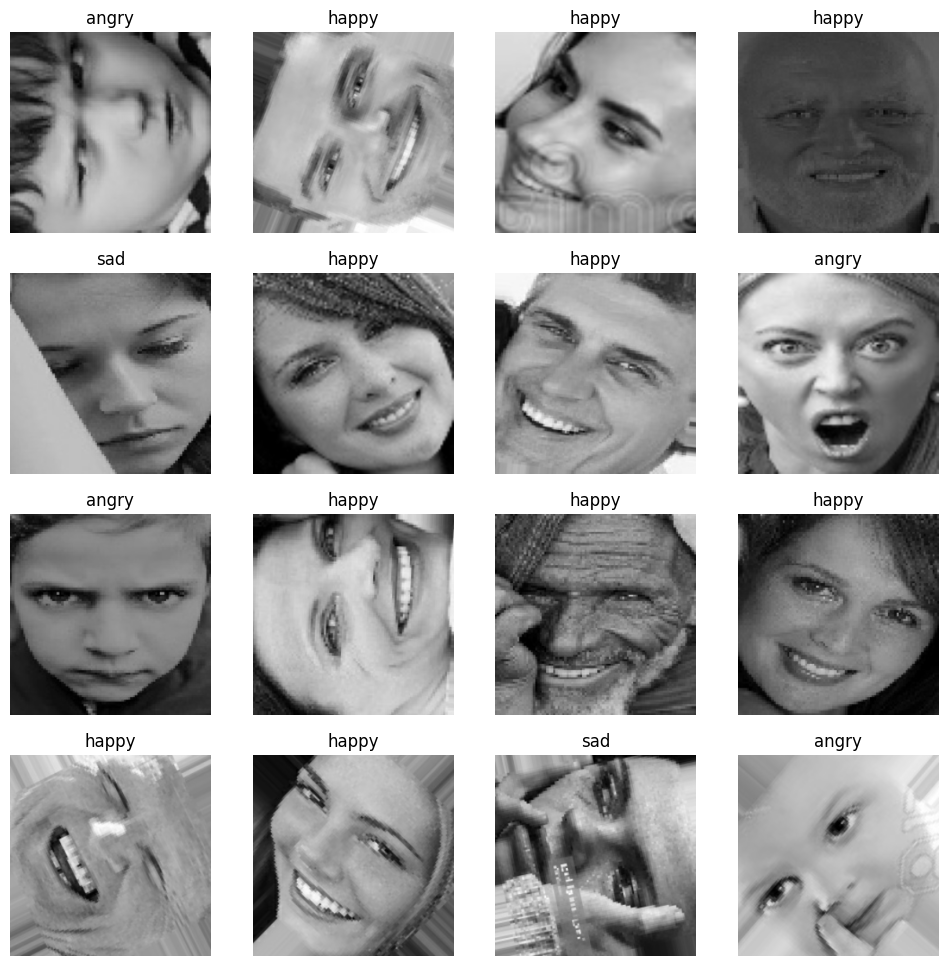

In [9]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')

## 5. Data Preparation

Prepare efficient data pipelines for training.

In [10]:
# Prepare efficient data pipelines
training_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


## 6. Data Augmentation

Let's apply data augmentation to reduce the model's overfitting.

In [11]:
# Setup a resize and rescale layer
resize_rescaling_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

`@tf.function` Decorator

This converts the function into a TensorFlow graph for optimization.
It speeds up execution by compiling it into a TensorFlow graph.

In [ ]:
# Create a data augmentation layer using TensorFlow
data_augment_layers = tf.keras.Sequential([
    RandomRotation(factor = 0.2),
    RandomFlip('horizontal',),
    RandomContrast(factor=0.1)
])

@tf.function
def augment_layer(image, label):
  return data_augment_layers(resize_rescaling_layers(image), training = True), label

##  Modelling
Let's start out modelling experiment with Lenet Model Architecture.

### Lenet Model

In [12]:
# Lets create Lenet Model
lenet_model = tf.keras.models.Sequential([
    InputLayer(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    resize_rescaling_layers,

    # 1st Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # 1st Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'],
          activation = 'softmax')
])

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

Setup loss and metrics for the training.
1. Loss: In this case we are using categorical crossentropy loss since we have set our output classes to be categorical which represents the classes as one hot vectors [0,0,0] - Angry, [0,0,1] = Sad, [0,1,0] = Happy

2. Metrics = We are defining categorical accuracy to check whether predicted category is close to actual category.
Moreover, we are setting up Top_k_accuracy to see whether the top k classes with higher probability are close to actual value or not.

### Compile and Train the model

In [13]:
# Setup loss and metrics
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'Categorical_Accuracy'), TopKCategoricalAccuracy(k = 2, name = 'Top_k_Accuracy')]

In [14]:
# Compile the model
lenet_model.compile(optimizer = Adam(CONFIGURATION['LEARNING_RATE']),
                    loss = loss,
                    metrics = metrics)

In [15]:
# Fit the model
lenet_model_history = lenet_model.fit(train_dataset,
                                      validation_data = val_dataset,
                                      epochs = CONFIGURATION['N_EPOCHS'],
                                      )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step - Categorical_Accuracy: 0.5200 - Top_k_Accuracy: 0.8057 - loss: 1.0716 - val_Categorical_Accuracy: 0.3626 - val_Top_k_Accuracy: 0.7858 - val_loss: 1.1689
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - Categorical_Accuracy: 0.7324 - Top_k_Accuracy: 0.9103 - loss: 0.6492 - val_Categorical_Accuracy: 0.5759 - val_Top_k_Accuracy: 0.8292 - val_loss: 0.9642
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - Categorical_Accuracy: 0.8232 - Top_k_Accuracy: 0.9571 - loss: 0.4399 - val_Categorical_Accuracy: 0.3942 - val_Top_k_Accuracy: 0.6655 - val_loss: 2.3825
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - Categorical_Accuracy: 0.8818 - Top_k_Accuracy: 0.9749 - loss: 0.3111 - val_Categorical_Accuracy: 0.4535 - val_Top_k_Accuracy: 0.6699 - val_loss: 2.5424
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - Categorical_Accuracy: 0.9156 - Top_k_Accuracy: 0.9838 - loss: 0.2533 - val_Categorical_Accuracy: 0.6629 - val_To

## 7. Evaluate the model

Let's evaluate the model's performance using the validation data and plot the loss and accuracy curves.

In [16]:
# Evaluate the model
cat_accuracy, top_k_accuracy, loss =  lenet_model.evaluate(val_dataset)

print(f'\n- Categorical_Accuracy: {cat_accuracy}\n- Top_k_Accuracy: {top_k_accuracy}\n- loss: {loss}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - Categorical_Accuracy: 0.7490 - Top_k_Accuracy: 0.9023 - loss: 1.1036

- Categorical_Accuracy: 1.0369305610656738
- Top_k_Accuracy: 0.7594380974769592
- loss: 0.9130816459655762


Plot loss curves for both validation and training dataset





In [ ]:
# PLot loss curves
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 1)
plt.plot(lenet_model_history.history['loss'])
plt.plot(lenet_model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])

# Plot accuracy curves
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 2)
plt.plot(lenet_model_history.history['Categorical_Accuracy'])
plt.plot(lenet_model_history.history['val_Categorical_Accuracy'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])

NameError: name 'lenet_model_history' is not defined

<Figure size 1000x700 with 0 Axes>

## 8. Save the model

In [ ]:
# Save the model
# lenet_model.save('lenet_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 9. Make predictions on a test image

Using the trained model, make predictions on the random images of unseen data.

In [ ]:
# lenet_model = tf.keras.models.load_model('/content/drive/MyDrive/HumanEmotionDetection/lenet_model.h5')

### 9.1 Prediction on a sample random image

In [ ]:
# Load a sample image from the data
sample_image = cv2.imread('/content/Emotions Dataset/Emotions Dataset/test/happy/100610.jpg_brightness_1.jpg')

# Display the image
plt.figure(figsize = (4,4))
plt.imshow(sample_image)
plt.axis('off')

In [ ]:
# Turn the sample image into a tensor
sample_image_tensor = tf.constant(sample_image, dtype = tf.float32)

# Check image dimemsions
print(f'Sample image tensor dimensions: {sample_image_tensor.shape}')

# Add an extra dimension for batch size to represent our image as (batch_size, im_size, im_size, channels)(1, 224, 224, 3)
sample_image_tensor_dim = tf.expand_dims(sample_image_tensor, axis = 0)

# Print the dimensions after adding an extra dim
print(f'\nImage dimensions after adding extra dimension (batch_size, im_size, im_size, channels) -> {sample_image_tensor_dim.shape}\n')

# Let's now try to make prediction on the image
pred_probs = lenet_model.predict(sample_image_tensor_dim)

# Turn the probabilities into class labels
print(f'Predicted Class Label: {CLASS_NAMES[tf.argmax(pred_probs[0], axis = 0).numpy()].upper()}')


### 9.2. Making predictions on multiple random images

Let's functionize the above code to make it work for picking random images from the given directory and plotting them against the truth labels.

**Explanation:**

`[dirnames for (dirnames, _, _) in os.walk(data_dir)][1:]`

* `os.walk(data_dir):`

- `os.walk()` generates tuples for each directory in the specified directory tree `(data_dir)`.

Each tuple has three elements:

- `dir`: The current directory path.
- `filepath`: A list of subdirectories in that directory (we're not using it here, hence _ ).
- `filename`: A list of files in that directory (also ignored here with _ ).


**List Comprehension:**

* `[dir for (dir, _, _) in os.walk(data_dir)]` creates a list of directory paths `(dir)` generated by `os.walk()`.

* Only the directory names are retained, and subdirectory and file lists are ignored.


Sample Output:

`['/content/Emotions Dataset/Emotions Dataset/train/happy',`

 `'/content/Emotions Dataset/Emotions Dataset/train/angry',`

 `'/content/Emotions Dataset/Emotions Dataset/train/sad']`

In [ ]:
# Create a function to make predictions on multiple images picked at random
def make_prediction_random_images(data_dir, model):

  """
  This function makes the predictions on randomly picked images from the given
  directory and plots them against the truth labels.

    Args:
      - data_dir : it takes the path of the data
      - model : the model for making predictions
  """

  # Extract paths from the data directory
  paths = [dirnames for (dirnames, _, _) in os.walk(data_dir)][1:]

  # Setup figure size
  plt.figure(figsize = (12, 6))

  for i in range(6):
    # Plot 6 random images and make prediction on it using the model
    plt.subplot(2, 3, i + 1)

    # Randomly select a path from paths
    random_path = random.choice(paths)

    # Choose an image randomly from the random path
    random_image = random.choice(os.listdir(random_path))
    random_image_path = random_path + '/' + random_image

    # Read image
    read_image = cv2.imread(random_image_path)

    # Turn the image into tensor
    image_tensor = tf.constant(read_image, dtype = tf.float32)

    # Fetch the actual label from the image
    actual_label = random_path.split('/')[-1]

    # Add an extra dimension to the image
    image_tensor_dim = tf.expand_dims(image_tensor, axis = 0)

    # Make prediction on the image
    pred_probs = model.predict(image_tensor_dim)

    # Fetch predicted class label
    pred_class_label = CLASS_NAMES[tf.argmax(pred_probs[0], axis = 0).numpy()]

    # Display the images
    plt.imshow(image_tensor/255.)
    plt.title(f'Actual Label : {actual_label}\nPredicted Label : {pred_class_label}\nPrediction Probabilty: {np.round(max(pred_probs[0]) * 100, 2)}%')

  plt.tight_layout()

  return None

In [ ]:
make_prediction_random_images(val_dir, lenet_model)

### 9.3 Create the Confusion Matrix

In [ ]:
# Let's draw confusion matrix
predicted = []
labels = []

for im, label in val_dataset:
  labels.append(label)
  predicted.append(lenet_model(im))

In [ ]:
print(len(labels), labels)

We will now process the true labels (labels) and predicted outputs (predicted) of a model to prepare them for evaluation.

1. `np.argmax(labels, axis=-1):`

* Converts the one-hot encoded true labels into their class indices along the last axis.

2. `flatten():`

* Flattens the arrays into 1D to simplify comparison.

3. `Concatenation:`

* Combines the processed labels and predictions from all batches (except the last and the last batch separately) into single 1D arrays:
* `lab:` Contains the true class indices.
* `preds:` Contains the predicted class indices.

The result is two 1D arrays (lab and preds) that are ready for metrics computation, such as accuracy, precision, or recall.

In [ ]:
# We will now process the true labels (labels) and predicted outputs (predicted)
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
preds = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

print(np.argmax(labels[:-1], axis = -1).flatten())
print(np.argmax(predicted[:-1], axis = -1).flatten())

In [ ]:
# Build the confusion matrix
cm = confusion_matrix(lab, preds)
print(cm)

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot= True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')